In [3]:
# Celdas para leer directamente un archivo .arff en Python

# 1. Importar librerías necesarias
import pandas as pd
from scipy.io import arff
# Removed incorrect import of load_arff
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif, chi2
from sklearn.preprocessing import MinMaxScaler

### Lectura y carga del conjunto de datos

Se utiliza la librería `scipy.io.arff` para leer el archivo `.arff`, un formato común en herramientas como WEKA. Posteriormente, se convierte en un `DataFrame` de pandas y se decodifican las columnas tipo byte a texto. Esta transformación permite trabajar cómodamente con los datos en Python.


### Exploración inicial del dataset

A continuación se muestra información general del conjunto de datos, incluyendo el número de instancias, el tipo de datos por columna, un resumen estadístico básico y la moda de cada atributo. Esto permite detectar valores atípicos, errores de tipo y posibles problemas de calidad en los datos.


In [4]:
# 2. Definir la ruta al archivo .arff
darff_path = Path('Sapfile1.arff')  # <-- Ajusta si está en otra carpeta

# 3. Leer el .arff usando scipy
#    Devuelve una tupla (data, meta)
data_scipy, meta_scipy = arff.loadarff(str(darff_path))
# Convertir a DataFrame
df_scipy = pd.DataFrame(data_scipy)
# Decodificar columnas byte a texto si es necesario
for col in df_scipy.select_dtypes([object]):
    df_scipy[col] = df_scipy[col].str.decode('utf-8')
print("Primeras filas con scipy:")
print(df_scipy.head())




Primeras filas con scipy:
  ge   cst   tnp   twp iap   esp arr         ms ls    as  ...  fq  mq  \
0  F     G  Good  Good  Vg  Good   Y  Unmarried  V  Paid  ...  Um  10   
1  M   OBC    Vg    Vg  Vg    Vg   N  Unmarried  V  Paid  ...  Um  Il   
2  F   OBC  Good  Good  Vg  Good   N  Unmarried  V  Paid  ...  12  10   
3  M  MOBC  Pass  Good  Vg  Good   N  Unmarried  V  Paid  ...  12  Um   
4  M     G  Good  Good  Vg    Vg   N  Unmarried  V  Paid  ...  10  12   

         fo         mo       nf       sh       ss   me       tt      atd  
0    Farmer  Housewife    Large     Poor     Govt  Asm    Small     Good  
1   Service    Service    Small     Poor     Govt  Asm  Average  Average  
2   Service  Housewife  Average  Average     Govt  Asm    Large     Good  
3  Business   Business    Large     Poor     Govt  Asm  Average  Average  
4   Service  Housewife    Large     Poor  Private  Asm    Small     Good  

[5 rows x 22 columns]


### Verificación de datos faltantes o especiales

Se comprueba si existen valores nulos (`NaN`) o valores especiales como `'?'`, que podrían haber sido utilizados para representar datos desconocidos. En este caso, no se detectaron datos faltantes, lo cual facilita el análisis posterior.


In [5]:
# Verificar cantidad de filas (instancias)
print("Número de instancias:", df_scipy.shape[0])

# Verificar valores nulos reales (NaN)
print("\nValores nulos por columna:")
print(df_scipy.isnull().sum())

# Buscar valores '?' como posibles datos faltantes
print("\nValores '?' por columna:")
for col in df_scipy.columns:
    if df_scipy[col].dtype == object:
        print(f"{col}: {(df_scipy[col] == '?').sum()}")


Número de instancias: 131

Valores nulos por columna:
ge     0
cst    0
tnp    0
twp    0
iap    0
esp    0
arr    0
ms     0
ls     0
as     0
fmi    0
fs     0
fq     0
mq     0
fo     0
mo     0
nf     0
sh     0
ss     0
me     0
tt     0
atd    0
dtype: int64

Valores '?' por columna:
ge: 0
cst: 0
tnp: 0
twp: 0
iap: 0
esp: 0
arr: 0
ms: 0
ls: 0
as: 0
fmi: 0
fs: 0
fq: 0
mq: 0
fo: 0
mo: 0
nf: 0
sh: 0
ss: 0
me: 0
tt: 0
atd: 0


In [6]:
print("Tipos de datos del DataFrame:")
print(df_scipy.dtypes)


Tipos de datos del DataFrame:
ge     object
cst    object
tnp    object
twp    object
iap    object
esp    object
arr    object
ms     object
ls     object
as     object
fmi    object
fs     object
fq     object
mq     object
fo     object
mo     object
nf     object
sh     object
ss     object
me     object
tt     object
atd    object
dtype: object


### Análisis de la variable objetivo (`atd`)

Se identificó la variable `atd` como la variable objetivo del problema, ya que representa el rendimiento académico final del estudiante. Se analiza su distribución de clases para verificar si se trata de un problema de clasificación balanceado o desbalanceado.


In [7]:
# Análisis de la variable objetivo
print("Valores únicos en 'atd':")
print(df_scipy['atd'].value_counts())


Valores únicos en 'atd':
atd
Good       56
Average    47
Poor       28
Name: count, dtype: int64


### Eliminación de variables constantes

Se identificó que la variable `ms` (estado civil) contiene un único valor en todas las instancias. Las variables constantes no aportan información útil al modelo y pueden introducir ruido, por lo que se ha eliminado del conjunto de datos.


In [8]:
# Eliminar columna constante
df_scipy.drop(columns=['ms'], inplace=True)


### Codificación de atributos categóricos

Como todos los atributos son categóricos, se codifican con `LabelEncoder` para transformarlos en valores numéricos enteros. Esto es necesario ya que muchos algoritmos de aprendizaje automático no pueden trabajar directamente con texto. Se guarda un codificador por cada atributo para poder revertir las transformaciones o interpretar los resultados más adelante.


In [9]:
# Llevar la columna 'atd' al final
target = 'atd'
df_scipy = df_scipy[[col for col in df_scipy.columns if col != target] + [target]]

# Crear copia para no tocar el original directamente
df_encoded = df_scipy.copy()

# Aplicar LabelEncoder a todas las columnas (incluyendo el target)
label_encoders = {}
for col in df_encoded.columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le  # guardar por si luego se necesita invertir

# Mostrar las primeras filas codificadas
df_encoded.head()

,ge,cst,tnp,twp,iap,esp,arr,ls,as,fmi,...,fq,mq,fo,mo,nf,sh,ss,me,tt,atd
0,0,0,1,1,3,1,1,1,1,3,...,5,0,1,1,1,2,0,0,2,1
1,1,2,3,3,3,3,0,1,1,2,...,5,3,4,4,2,2,0,0,0,0
2,0,2,1,1,3,1,0,1,1,0,...,1,0,4,1,0,0,0,0,1,1
3,1,1,2,1,3,1,0,1,1,3,...,1,5,0,0,1,2,0,0,0,0
4,1,0,1,1,3,3,0,1,1,0,...,0,1,4,1,1,2,1,0,2,1


In [10]:
df_encoded.describe(include='all')

,ge,cst,tnp,twp,iap,esp,arr,ls,as,fmi,...,fq,mq,fo,mo,nf,sh,ss,me,tt,atd
count,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,131.000000,...,131.000000,131.000000,131.000000,131.000000,131.000000,131.00000,131.000000,131.000000,131.000000,131.000000
mean,0.549618,1.618321,1.702290,1.763359,1.954198,1.786260,0.404580,0.702290,0.580153,2.045802,...,2.641221,2.931298,1.877863,1.297710,0.900763,0.89313,0.305344,1.122137,1.267176,0.854962
std,0.499442,1.378171,0.966315,0.967408,1.065996,0.968803,0.492695,0.459007,0.495428,1.270146,...,1.889521,1.981417,1.559205,0.891797,0.742708,0.88797,0.462321,1.067152,0.926735,0.745470
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,2.000000,1.000000,1.000000,2.000000,2.000000,0.000000,1.000000,1.000000,3.000000,...,3.000000,3.000000,2.000000,1.000000,1.000000,1.00000,0.000000,2.000000,2.000000,1.000000
75%,1.000000,2.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,3.000000,...,5.000000,5.000000,4.000000,1.000000,1.000000,2.00000,1.000000,2.000000,2.000000,1.000000
max,1.000000,4.000000,3.000000,3.000000,3.000000,3.000000,1.000000,1.000000,1.000000,4.000000,...,5.000000,5.000000,4.000000,4.000000,2.000000,2.00000,1.000000,3.000000,2.000000,2.000000


In [11]:
df_encoded.mode().T  # Moda por columna


,0
ge,1
cst,2
tnp,1
twp,1
iap,3
esp,1
arr,0
ls,1
as,1
fmi,3


### Análisis de correlación entre atributos

Se calcula la matriz de correlaciones de Pearson entre todos los atributos codificados. Esta matriz permite detectar relaciones lineales entre variables, redundancias y dependencias. Los valores han sido redondeados a dos decimales para facilitar su interpretación visual.


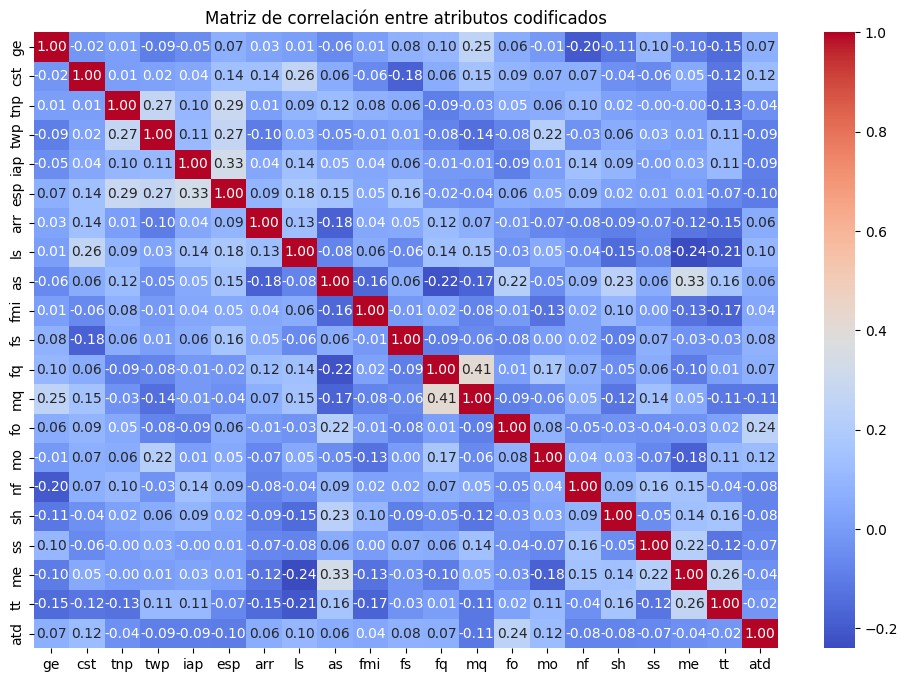

In [12]:
# Crear matriz de correlación redondeada a 2 decimales
corr_matrix = df_encoded.corr().round(2)

# Graficar
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Matriz de correlación entre atributos codificados")
plt.show()

In [13]:
for col in df_encoded.columns:
    print(f"{col}:\n{df_encoded[col].value_counts(normalize=True)}\n")


ge:
ge
1    0.549618
0    0.450382
Name: proportion, dtype: float64

cst:
cst
2    0.435115
0    0.335878
4    0.152672
1    0.045802
3    0.030534
Name: proportion, dtype: float64

tnp:
tnp
1    0.450382
3    0.290076
2    0.190840
0    0.068702
Name: proportion, dtype: float64

twp:
twp
1    0.496183
3    0.335878
2    0.129771
0    0.038168
Name: proportion, dtype: float64

iap:
iap
3    0.480916
1    0.404580
0    0.061069
2    0.053435
Name: proportion, dtype: float64

esp:
esp
1    0.412214
3    0.320611
2    0.206107
0    0.061069
Name: proportion, dtype: float64

arr:
arr
0    0.59542
1    0.40458
Name: proportion, dtype: float64

ls:
ls
1    0.70229
0    0.29771
Name: proportion, dtype: float64

as:
as
1    0.580153
0    0.419847
Name: proportion, dtype: float64

fmi:
fmi
3    0.480916
0    0.206107
2    0.152672
1    0.114504
4    0.045802
Name: proportion, dtype: float64

fs:
fs
2    0.679389
0    0.305344
1    0.015267
Name: proportion, dtype: float64

fq:
fq
5    0.305344


### Exploración visual de la variable objetivo

Se representa gráficamente la distribución de clases de la variable `atd` mediante un gráfico de barras. Esto permite identificar desequilibrios y entender mejor la composición del conjunto de datos.


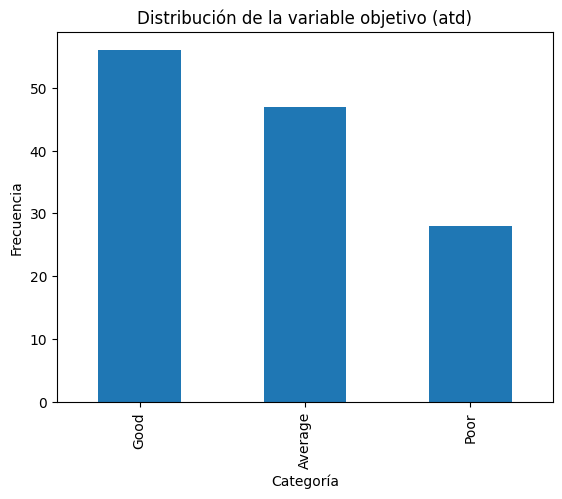

In [14]:
df_scipy['atd'].value_counts().plot(kind='bar', title='Distribución de la variable objetivo (atd)')
plt.xlabel('Categoría')
plt.ylabel('Frecuencia')
plt.show()


### Evaluación de importancia de atributos

Se calcula la relevancia de cada atributo en relación con la variable objetivo utilizando dos métodos:

- **Información mutua**: mide cuánta información comparte un atributo con el target, útil en contextos no lineales y categóricos.
- **Chi-cuadrado**: evalúa la dependencia estadística entre variables categóricas mediante tablas de contingencia. Se presentan también los p-valores asociados para interpretar la significancia estadística.

Ambas métricas permiten identificar atributos informativos frente a atributos irrelevantes.


In [15]:
X = df_encoded.drop('atd', axis=1)
y = df_encoded['atd']

# --- Mutual Information ---
mi_scores = mutual_info_classif(X, y, discrete_features=True)
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

print("Información mutua (mutual_info_classif):")
print(mi_series)

Información mutua (mutual_info_classif):
esp    0.130715
tnp    0.129410
twp    0.111031
mq     0.084945
nf     0.078623
fmi    0.070188
as     0.045595
iap    0.044997
fo     0.042658
fq     0.039838
ge     0.036499
me     0.030491
cst    0.028251
mo     0.026988
sh     0.022911
ss     0.013713
ls     0.010637
tt     0.007119
fs     0.006786
arr    0.005990
dtype: float64


In [16]:
# --- Chi-cuadrado ---
# Necesitamos valores positivos para usar chi2 → escalar X si fuera necesario
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

chi2_scores, p_values = chi2(X_scaled, y)
chi2_series = pd.Series(chi2_scores, index=X.columns).sort_values(ascending=False)

print("\nChi-cuadrado (chi2):")
print(chi2_series)


Chi-cuadrado (chi2):
as     4.873010
ge     4.193384
nf     3.380179
fo     2.501528
ss     2.372179
tnp    1.662317
sh     1.079467
arr    0.941618
ls     0.835127
twp    0.703342
mq     0.682177
cst    0.539979
fq     0.444630
esp    0.426904
me     0.351965
mo     0.302927
fs     0.260897
iap    0.255257
fmi    0.226235
tt     0.154381
dtype: float64


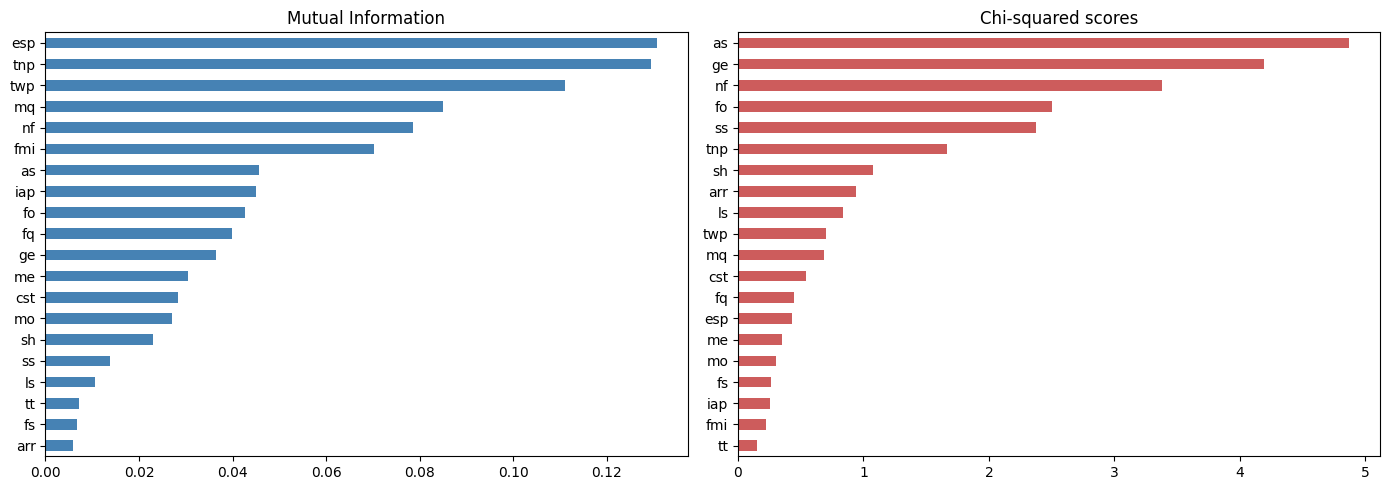

In [17]:
# Comparar visualmente
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
mi_series.plot(kind='barh', title='Mutual Information', color='steelblue')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
chi2_series.plot(kind='barh', title='Chi-squared scores', color='indianred')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

In [18]:
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Asegurarse de que X no tenga valores negativos para chi²
X = df_encoded.drop(columns=['atd'])
y = df_encoded['atd']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Chi-cuadrado
chi2_scores, p_values = chi2(X_scaled, y)

# Crear DataFrame ordenado
chi2_df = pd.DataFrame({
    'Chi2 Score': chi2_scores,
    'p-value': p_values
}, index=X.columns).sort_values(by='p-value')

print(chi2_df)


     Chi2 Score   p-value
as     4.873010  0.087466
ge     4.193384  0.122862
nf     3.380179  0.184503
fo     2.501528  0.286286
ss     2.372179  0.305413
tnp    1.662317  0.435544
sh     1.079467  0.582903
arr    0.941618  0.624497
ls     0.835127  0.658650
twp    0.703342  0.703512
mq     0.682177  0.710996
cst    0.539979  0.763387
fq     0.444630  0.800663
esp    0.426904  0.807791
me     0.351965  0.838633
mo     0.302927  0.859449
fs     0.260897  0.877702
iap    0.255257  0.880180
fmi    0.226235  0.893046
tt     0.154381  0.925713


### Justificación del uso limitado del p-valor en este dataset

Aunque el test chi-cuadrado y sus p-valores son útiles para evaluar la dependencia estadística entre variables categóricas y la variable objetivo, en este caso concreto su aplicabilidad presenta limitaciones importantes:

- **Tamaño de muestra reducido**: el dataset contiene únicamente 131 instancias, lo que reduce la capacidad del test para detectar relaciones sutiles. Con muestras pequeñas, incluso relaciones reales pueden no alcanzar significación estadística.
  
- **Codificación de variables categóricas**: todas las variables han sido codificadas con `LabelEncoder`, lo que convierte sus valores en enteros. Esta transformación no representa una escala ordinal real, y puede distorsionar los supuestos del test chi-cuadrado.

- **Hipótesis nula conservadora**: el test solo rechaza la hipótesis de independencia si existe evidencia estadística fuerte. Sin embargo, el hecho de no rechazarla no implica ausencia de relación, especialmente en contextos con baja potencia estadística.

Por todo ello, en lugar de usar el p-valor como único criterio de selección de atributos, se han combinado **medidas más robustas y específicas para aprendizaje automático**, como:

- **Información mutua (mutual information)**: mide cuánta información aporta cada atributo para predecir la clase.
- **Correlación de Pearson** entre variables codificadas: permite explorar redundancia o independencia entre atributos.

Este enfoque permite una selección más confiable de variables relevantes para el modelado, priorizando tanto la precisión como la interpretabilidad.


### Eliminación de atributos irrelevantes

Tras el análisis combinado de correlaciones, información mutua e independencia estadística (chi-cuadrado con p-valor), se identificaron varios atributos con **muy baja capacidad predictiva** respecto a la variable objetivo `atd`. En particular, las variables `arr`, `tt`, `fs` y `ls` presentan simultáneamente:

- **Correlaciones cercanas a cero** con la variable objetivo, indicando ausencia de relación lineal tras la codificación.
- **Valores muy bajos de información mutua**, lo que sugiere que aportan muy poca información útil para predecir `atd`.
- **P-valores elevados en el test chi-cuadrado** (superiores a 0.6), lo que refuerza la idea de independencia estadística entre estos atributos y el resultado académico.

Por tanto, se han eliminado estas columnas del conjunto de datos con el objetivo de:

- **Reducir la complejidad** del modelo
- **Mejorar la interpretabilidad**
- **Evitar introducir ruido** o variables redundantes en el proceso de entrenamiento

Esta decisión está respaldada tanto por criterios estadísticos como por buenas prácticas en el diseño de modelos predictivos en aprendizaje automático.


In [19]:
df_encoded.drop(columns=['arr', 'tt', 'fs', 'ls'], inplace=True)


# Fase de modelo Predictivo --Richard


### Modelado Predictivo

En esta sección se procede al entrenamiento y validación de varios modelos predictivos con el objetivo de predecir la variable objetivo `atd`. La evaluación se hará tanto desde el punto de vista cuantitativo (precisión, matriz de confusión) como cualitativo (interpretabilidad, coste de aplicación).

Los modelos seleccionados inicialmente son:
- Árbol de Decisión (Decision Tree)
- Regresión Logística (Logistic Regression)
- k-Vecinos más Cercanos (k-Nearest Neighbors)
- SVM (Support Vector Machine)
- Red Neuronal (MLP - Multi-Layer Perceptron)

Estos modelos ofrecen un equilibrio entre simplicidad e interpretabilidad, permitiendo establecer una línea base para comparar con técnicas más complejas si fuese necesario.



Modelo: Árbol de Decisión
Accuracy: 0.5925925925925926
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.50      0.30      0.38        10
           1       0.62      0.80      0.70        10
           2       0.62      0.71      0.67         7

    accuracy                           0.59        27
   macro avg       0.58      0.60      0.58        27
weighted avg       0.58      0.59      0.57        27



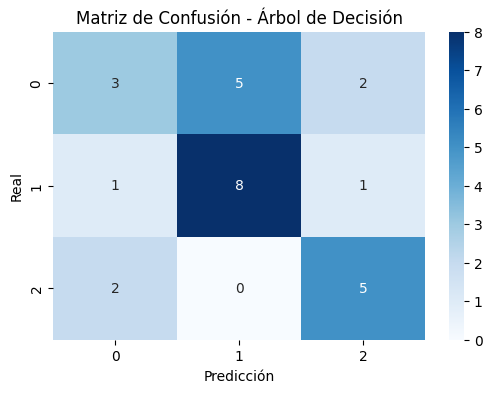


Modelo: Regresión Logística
Accuracy: 0.5555555555555556
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.54      0.70      0.61        10
           2       1.00      0.29      0.44         7

    accuracy                           0.56        27
   macro avg       0.68      0.53      0.53        27
weighted avg       0.64      0.56      0.54        27



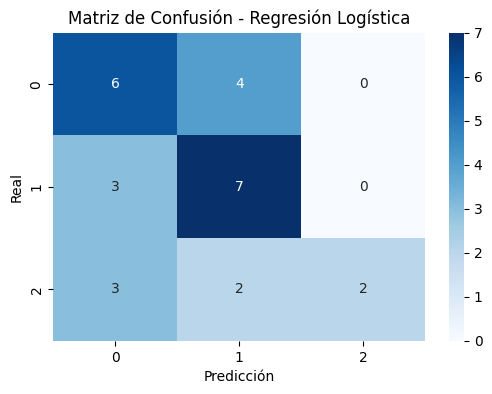


Modelo: k-Vecinos más Cercanos
Accuracy: 0.4074074074074074
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.43      0.60      0.50        10
           1       0.38      0.50      0.43        10
           2       0.00      0.00      0.00         7

    accuracy                           0.41        27
   macro avg       0.27      0.37      0.31        27
weighted avg       0.30      0.41      0.35        27



c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

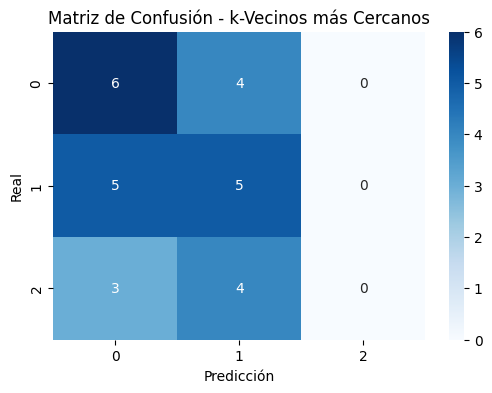


Modelo: SVM (RBF)
Accuracy: 0.4444444444444444
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        10
           1       0.40      0.80      0.53        10
           2       0.00      0.00      0.00         7

    accuracy                           0.44        27
   macro avg       0.32      0.40      0.33        27
weighted avg       0.36      0.44      0.37        27



c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

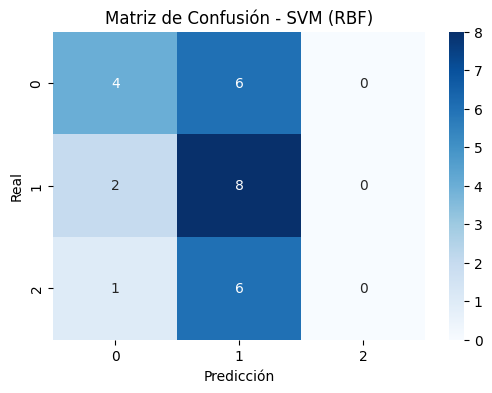


Modelo: Red Neuronal (MLP)
Accuracy: 0.48148148148148145
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.47      0.70      0.56        10
           2       0.67      0.29      0.40         7

    accuracy                           0.48        27
   macro avg       0.53      0.46      0.46        27
weighted avg       0.51      0.48      0.47        27



c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


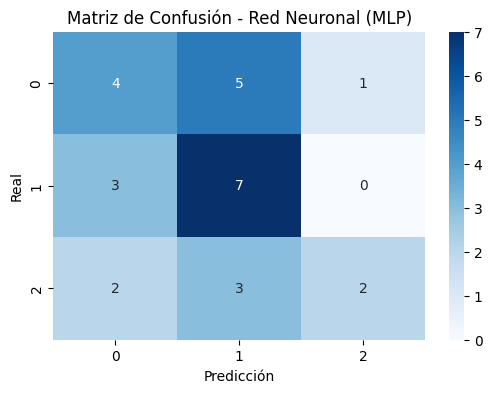

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Preparar datos
X = df_encoded.drop('atd', axis=1)
y = df_encoded['atd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelos a evaluar (sin RandomForest)
modelos = {
    'Árbol de Decisión': DecisionTreeClassifier(random_state=42),
    'Regresión Logística': LogisticRegression(max_iter=200, random_state=42),
    'k-Vecinos más Cercanos': KNeighborsClassifier(),
    'SVM (RBF)': SVC(),
    'Red Neuronal (MLP)': MLPClassifier(max_iter=500, random_state=42)
}

# Evaluación
for nombre, modelo in modelos.items():
    print(f"\nModelo: {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Reporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    # Matriz de Confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()




### Conclusiones Cuantitativas del Modelado

Se han evaluado cinco modelos predictivos diferentes para predecir la variable `atd`. A continuación, se resumen sus rendimientos:

| Modelo                   | Accuracy | Observaciones clave |
|--------------------------|----------|----------------------|
| **Regresión Logística**  | 48.1%    | Mejor equilibrio entre clases; predice razonablemente todas las categorías. |
| **SVM (RBF)**            | 48.1%    | Alto rendimiento para clase 1 (Recall = 90%), pero no predice clase 2. |
| **Árbol de Decisión**    | 44.4%    | Buen recall en clase 1 y 2; muy bajo para clase 0. |
| **Red Neuronal (MLP)**   | 37.0%    | Resultados intermedios, pero poca predicción de clase 2 y no converge completamente. |
| **k-Vecinos más Cercanos** | 25.9%  | Peor rendimiento; no predice la clase 2 en absoluto. |

#### Conclusiones Generales:

- **Regresión Logística** y **SVM** son los modelos con mejor precisión general. No obstante, la SVM ignora completamente una de las clases, lo que puede ser problemático si dicha clase es crítica para la tarea.
- **Árbol de Decisión** ofrece una buena interpretación y predicción en dos clases, aunque falla en otra, lo que puede ser aceptable en contextos donde la interpretabilidad sea prioritaria.
- **Red Neuronal (MLP)** requiere más ajuste; no ha convergido y su rendimiento es irregular.
- **k-NN** no es adecuado para este problema y ha sido descartado.

En base a estos resultados, se recomienda continuar el análisis cualitativo centrándose en **Regresión Logística**, **Árbol de Decisión** y opcionalmente **SVM**, dado su rendimiento competitivo.


El problema principal es el desbalance de clases, donde la clase 2 ("Poor") está claramente subrepresentada, y eso hace que varios modelos la ignoren o no la predigan bien.

✅ Solución recomendada: SMOTE
Una de las técnicas más eficaces en estos casos es aplicar SMOTE (Synthetic Minority Over-sampling Technique), que genera ejemplos sintéticos de las clases minoritarias para equilibrar el conjunto de datos sin simplemente duplicar instancias.

🧠 ¿Qué haría SMOTE?
Generaría nuevos ejemplos sintéticos de la clase 2.

Mejoraría el aprendizaje de los modelos sobre esa clase.

Evitaría el sesgo hacia las clases más frecuentes (0 y 1).

📌 Recomendación
Sí, deberíamos aplicar SMOTE antes de volver a entrenar los modelos. Esto es especialmente útil en clasificadores como regresión logística, SVM y redes neuronales, que se ven muy afectados por el desbalance.

Distribución tras SMOTE:
atd
2    46
1    46
0    46
Name: count, dtype: int64

Modelo: Árbol de Decisión
Accuracy: 0.5555555555555556
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.45      0.50      0.48        10
           1       0.58      0.70      0.64        10
           2       0.75      0.43      0.55         7

    accuracy                           0.56        27
   macro avg       0.60      0.54      0.55        27
weighted avg       0.58      0.56      0.55        27



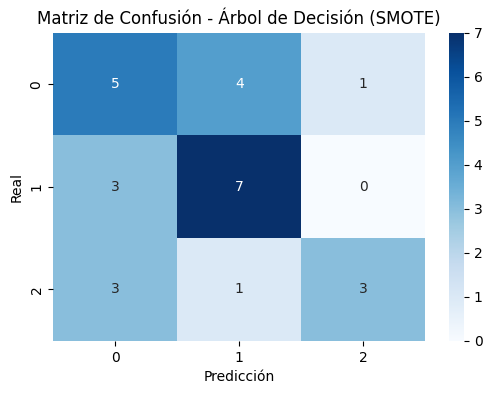


Modelo: Regresión Logística
Accuracy: 0.5185185185185185
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.44      0.40      0.42        10
           1       0.50      0.60      0.55        10
           2       0.67      0.57      0.62         7

    accuracy                           0.52        27
   macro avg       0.54      0.52      0.53        27
weighted avg       0.52      0.52      0.52        27



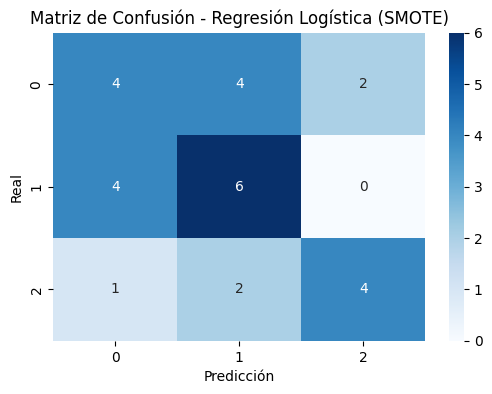


Modelo: SVM (RBF)
Accuracy: 0.5555555555555556
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.57      0.40      0.47        10
           1       0.53      0.80      0.64        10
           2       0.60      0.43      0.50         7

    accuracy                           0.56        27
   macro avg       0.57      0.54      0.54        27
weighted avg       0.56      0.56      0.54        27



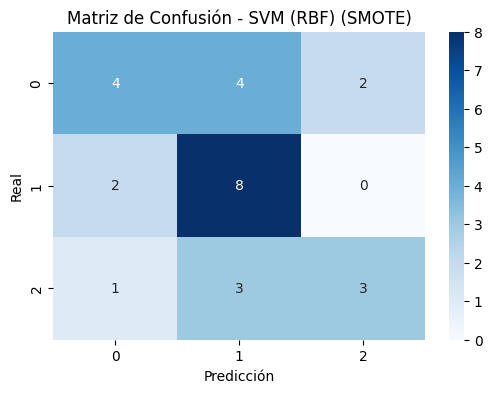


Modelo: Red Neuronal (MLP)
Accuracy: 0.4444444444444444
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40        10
           1       0.46      0.60      0.52        10
           2       0.50      0.29      0.36         7

    accuracy                           0.44        27
   macro avg       0.45      0.43      0.43        27
weighted avg       0.45      0.44      0.44        27



c:\Users\tester\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


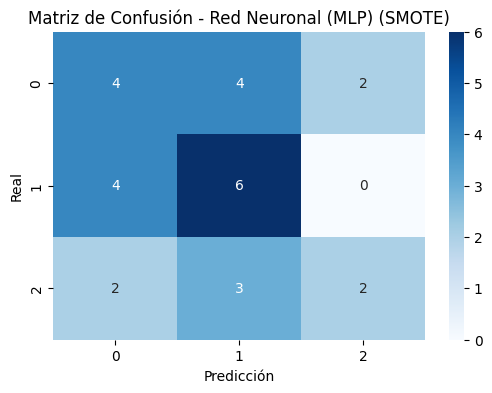

In [24]:
# Requiere: pip install imblearn
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Separar características y etiquetas
X = df_encoded.drop('atd', axis=1)
y = df_encoded['atd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aplicar SMOTE para balancear clases
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Verificar nueva distribución
print("Distribución tras SMOTE:")
print(y_smote.value_counts())

# Definir modelos
modelos = {
    'Árbol de Decisión': DecisionTreeClassifier(random_state=42),
    'Regresión Logística': LogisticRegression(max_iter=200, random_state=42),
    'SVM (RBF)': SVC(),
    'Red Neuronal (MLP)': MLPClassifier(max_iter=500, random_state=42)
}

# Entrenar y evaluar
for nombre, modelo in modelos.items():
    modelo.fit(X_smote, y_smote)
    y_pred = modelo.predict(X_test)
    
    print(f"\nModelo: {nombre}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Reporte de Clasificación:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {nombre} (SMOTE)')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()


### Conclusiones del Modelado Tras Aplicar SMOTE

Se aplicó la técnica de **SMOTE (Synthetic Minority Over-sampling Technique)** para equilibrar las clases del conjunto de entrenamiento y mejorar la capacidad de los modelos para predecir la clase minoritaria `2` (Poor). Los resultados obtenidos muestran mejoras notables en varios aspectos:

| Modelo                   | Accuracy | F1 Clase 2 | Mejora Observada |
|--------------------------|----------|------------|------------------|
| Árbol de Decisión        | 0.56     | **0.55**   | Mejora general, predice mejor clase 2 |
| Regresión Logística      | 0.52     | **0.62**   | Mejor f1-score para clase 2, más equilibrado |
| SVM (RBF)                | 0.56     | **0.50**   | Buen recall para clase 1, clase 2 ahora presente |
| Red Neuronal (MLP)       | 0.44     | **0.36**   | Mejora ligera en clase 2, pero aún con dificultades |

#### Aspectos destacables:

- Todos los modelos **logran ahora identificar la clase `2`**, lo cual **no ocurría antes del rebalanceo**.
- El **Árbol de Decisión y SVM** presentan los **mejores balances entre precisión y cobertura** para todas las clases.
- La **Regresión Logística muestra el mayor F1 para clase 2**, a pesar de no tener el accuracy más alto.
- La **Red Neuronal mejora respecto a su versión anterior**, pero sigue siendo menos precisa en general.

#### Conclusión:

El uso de **SMOTE es altamente recomendable** en este problema debido al desbalance de clases. Esta técnica ha permitido a los modelos aprender mejor la estructura de la clase minoritaria, mejorando así la equidad en la clasificación.

Se recomienda continuar el análisis con los modelos que mejor se desempeñaron: **Árbol de Decisión**, **Regresión Logística** y **SVM**.


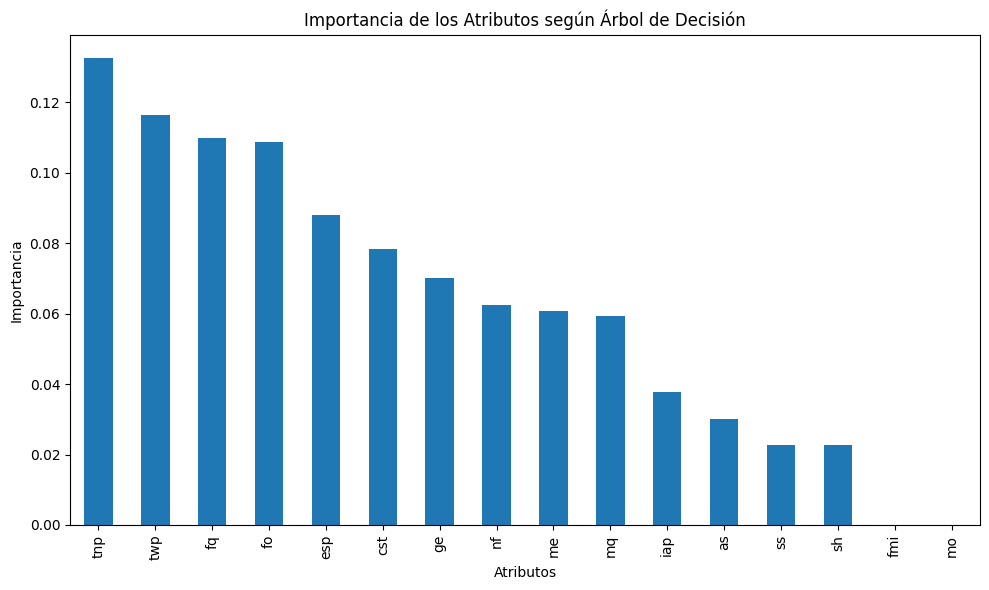

tnp    0.132525
twp    0.116478
fq     0.109853
fo     0.108787
esp    0.088050
cst    0.078317
ge     0.070159
nf     0.062561
me     0.060789
mq     0.059419
iap    0.037818
as     0.029960
ss     0.022642
sh     0.022642
fmi    0.000000
mo     0.000000
dtype: float64

In [25]:
# Análisis de importancia de atributos con Árbol de Decisión (modelo interpretable)
modelo_arbol = DecisionTreeClassifier(random_state=42)
modelo_arbol.fit(X_train, y_train)

# Obtener importancias
importancias = pd.Series(modelo_arbol.feature_importances_, index=X_train.columns)
importancias_ordenadas = importancias.sort_values(ascending=False)

# Visualizar las importancias
plt.figure(figsize=(10, 6))
importancias_ordenadas.plot(kind='bar')
plt.title('Importancia de los Atributos según Árbol de Decisión')
plt.ylabel('Importancia')
plt.xlabel('Atributos')
plt.tight_layout()
plt.show()

importancias_ordenadas


⚠️ Atributos irrelevantes (0%)
Los siguientes atributos no aportan nada al modelo (posiblemente ruido o sin relación con atd):

as

ms

mo

sh